In [1]:
import torch
import numpy as np
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Ellipse
import matplotlib.cm as cm

In [2]:
dataset = torch.load("proposals_offsetted_top_1000.pt")

In [ ]:
'''
res = dataset['data'][160]
print(res.keys())
image_id = res["image_id"]
instances = res["instances"]
proposals_offsetted = res["proposals_offsetted"]
print(image_id)
print(res['proposals_offsetted'].pred_boxes.tensor.size())
print(res['instances'].pred_boxes.tensor.size())
'''

In [3]:
def scatter(X, ax=None, top=None, color=None, 
            draw_cov=True, draw_samples=True, 
            format='proposals', linestyle=None, **kwargs):
    '''
    plot scatter points or scatter rectangles
    dim X = nb of points per image x dim of space
    '''
    
    ax = ax or plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])

    N = top if ((top is not None) and  top <= X.size(0)) else X.size(0)
    R = rect_for_plots(X[:N, :], format=format)
    
    if 'mu' in kwargs:
        mu_ini, cov, labels, avg_scores = kwargs['mu'], kwargs['cov'], kwargs['labels'], kwargs['avg_scores']
        mu = rect_for_plots(mu_ini, format=format)
        
        
        ulabels = np.sort(np.unique(labels.cpu().numpy()))[1:]
        ulabels = ulabels[np.argsort(params['avg_score'])]
        colors = cm.rainbow(np.linspace(0, 1, len(ulabels)))
        
        
        
        #Plot l=0 background
        if draw_samples:
            R_temp = R[labels==0]
            for i in range(R_temp.size(0)):
                ax.add_patch(
                            Rectangle((R_temp[i, 0].cpu().data.numpy(), R_temp[i, 1].cpu().data.numpy()), 
                              R_temp[i, 2].cpu().data.numpy(), R_temp[i, 3].cpu().data.numpy(), 
                              fill=False, color='gray', linewidth=1.5, alpha=0.1, linestyle='-'
                                     )
                            )        
        
        #Plot l>1 object clusters
        for l, c in zip(ulabels, colors):
            R_temp = R[labels==l]
            
            if draw_samples:
                #Draw cluster l
                for i in range(R_temp.size(0)):
                    ax.add_patch(
                                Rectangle((R_temp[i, 0].cpu().data.numpy(), R_temp[i, 1].cpu().data.numpy()), 
                                  R_temp[i, 2].cpu().data.numpy(), R_temp[i, 3].cpu().data.numpy(), 
                                  fill=False, color=c, linewidth=1.5, alpha=0.4, linestyle='-'
                                         )
                                )
            #Draw means
            ax.add_patch(
                        Rectangle((mu[l - 1, 0].cpu().data.numpy(), mu[l - 1, 1].cpu().data.numpy()), 
                            mu[l - 1, 2].cpu().data.numpy(), mu[l - 1, 3].cpu().data.numpy(), 
                            fill=False, color=c, linewidth=2, alpha=0.8
                                     )
                        )
            
            if draw_cov:
                #Draw variance
                draw_ellipse(mu_ini[l - 1,0:2].cpu().detach().numpy(), 
                             torch.diag(cov[l -1 , 0:2]).cpu().detach().numpy(), 
                             ax=ax, fc=c
                            )
                draw_ellipse(mu_ini[l - 1,2:4].cpu().detach().numpy(),
                             torch.diag(cov[l - 1, 2:4]).cpu().detach().numpy(), 
                             ax=ax, fc=c
                            )
        
        
    else:
        if color==None:
            reds = cm.get_cmap('Reds')
            colors = np.flip(reds(np.linspace(0, 1, R.size(0))),0)
        else:
            colors=[color for i in range(R.size(0))]
        
        linestyle = '-' if linestyle is None else linestyle
            
        for i in reversed(range(R.size(0))):
            ax.add_patch(
                        Rectangle((R[i, 0].cpu().data.numpy(), R[i, 1].cpu().data.numpy()), 
                          R[i, 2].cpu().data.numpy(), R[i, 3].cpu().data.numpy(), 
                          fill=False, color=colors[i], linewidth=1.5, alpha=0.5,
                           linestyle=linestyle
                                 )
                        )

    ax.axis('equal')
    return None



def rect_for_plots(rects, format='proposals'):
    '''
    input: N x 4 in format (coordinates upper left) x (coordinates bottom right)
    '''

    if format == 'proposals':
        R = torch.zeros_like(rects)
        R[:, 0]=rects[:, 0]
        R[:, 1]=rects[:, 3]
        R[:, 2]=rects[:, 2]-rects[:, 0]
        R[:, 3]=rects[:, 1] - rects[:,3]
        
    elif format == 'instances':
        R = torch.zeros_like(rects)
        R[:, 0] = rects[:,0] - 0.5*rects[:,2]
        R[:, 1] = rects[:, 1] - 0.5*rects[:, 3]
        R[:, 2] = rects[:, 2]
        R[:, 3] = rects[:, 3]
    
    else:
        X = torch.hstack((rects[:, 0].unsqueeze(1), rects[:, 2].unsqueeze(1)))
        Y = torch.hstack((rects[:, 1].unsqueeze(1), rects[:, 3].unsqueeze(1)))
        x_min, _ = torch.min(X, 1)
        y_min, _ = torch.min(Y, 1)
        x_max, _ = torch.max(X, 1)
        y_max, _ = torch.max(Y, 1)
        w = x_max - x_min
        h = y_max - y_min
        R = torch.hstack(
                (x_min.unsqueeze(1),
                y_min.unsqueeze(1),
                w.unsqueeze(1),
                h.unsqueeze(1))
            )
    
    return R

def draw_ellipse(pos, cov, ax=None, **kwargs):
    if type(pos) != np.ndarray:
        pos = to_numpy(poxs)
    if type(cov) != np.ndarray:
        cov = to_numpy(cov)
    ax = ax or plt.gca()
    U, s, Vt = np.linalg.svd(cov)
    angle = np.degrees(np.arctan2(U[1,0], U[0,0]))
    width, height = 2 * np.sqrt(s)
    for nsig in range(1, 6):
        ax.add_patch(Ellipse(pos, nsig*width, nsig*height, angle,
            alpha=0.5/nsig, **kwargs))

In [ ]:
'''
fig=plt.figure(figsize=(12,9))
ax = plt.gca()

scatter(res['proposals_offsetted'].pred_boxes.tensor, ax = ax, format='proposals', top=500)
scatter(res['instances'].pred_boxes.tensor, ax=ax, format='proposals',color='blue')
'''

In [4]:
from detectron2.structures import pairwise_iou

#The lower the nms_thr, the more the number of samples per cluster

def naive_estimation(res, nms_thr=0.5):

    #1- Compute pair-wise IoUs
    iou = pairwise_iou(res['instances'].pred_boxes, 
                       res['proposals_offsetted'].pred_boxes
                      )


    #2- Estimate the mixture parameters sequentially

    params={'mu':[], 'cov':[], 'pi':[], 'avg_score':[]}

    processed=0
    proposals_tensor = res['proposals_offsetted'].pred_boxes.tensor.clone()
    scores = res['proposals_offsetted'].scores.clone()

    mask = torch.ones(proposals_tensor.size(0))
    labels = torch.zeros_like(mask).long()

    for i in range(len(res['instances'].pred_boxes)):
        print('Number of remaining proposals: {}'.format(mask.sum()))

        cond = ((iou[i, :] >= nms_thr)*mask).bool()
        labels[cond]= i + 1
        current_cluster=proposals_tensor[cond]
        current_scores=scores[cond]

        #Compute mixture parameters
        N = current_cluster.size(0)
        X = current_cluster
        W = current_scores.unsqueeze(1).repeat(1, current_cluster.size(1))
        mu = (X*W).sum(0)/W.sum(0)
        cov = (1/N)*(((X - mu.repeat(X.size(0),1))**2)*W).sum(0)
        pi = N

        params['mu'].append(mu)
        params['cov'].append(cov)
        params['pi'].append(pi)
        params['avg_score'].append(current_scores.mean().item())


        #Suppress non-maximum boxes
        mask[iou[i, :] >= nms_thr] = 0

        processed += N
        print('{} boxes in cluster {} (mean score: {})'.format(N, i, current_scores.mean()))

    params['pi']=[params['pi'][i]/processed for i in range(len(params['pi']))]

    print('{} boxes (/{}) used to estimate the mixture parameters'.format(processed, len(res['proposals_offsetted'].pred_boxes)))
    
    return proposals_tensor, labels, params

In [ ]:
'''
proposals_tensor, labels, params = naive_estimation(res)
'''

In [5]:
from PIL import Image

def open_img_from_path(img_path: str):
    return np.array(Image.open(img_path))

def get_img_from_id(image_id, directory='/u/mernoult/ood-object-detection/datasets/coco/val2017/'):
    file_name = directory
    for _ in range(12 - len(str(image_id))):
        file_name += str(0)
    file_name += str(image_id) + '.jpg'
    print(file_name)
    image =  open_img_from_path(file_name)
    return image


In [ ]:
'''
fig=plt.figure(figsize=(12,9))
image = get_img_from_id(image_id)
plt.imshow(image)
ax = plt.gca()
print(params['mu'])
scatter(proposals_tensor, ax=ax, 
        mu = torch.vstack(params['mu']), 
        cov = torch.vstack(params['cov']),
        labels=labels, 
        avg_scores=params['avg_score'],
        draw_cov=True,
        draw_samples=False
       )
scatter(res['instances'].pred_boxes.tensor, ax=ax, 
        format='proposals',
        color='black',
        linestyle='--')
'''

Number of remaining proposals: 1000.0
52 boxes in cluster 0 (mean score: 0.37084639072418213)
Number of remaining proposals: 948.0
31 boxes in cluster 1 (mean score: 0.40143370628356934)
Number of remaining proposals: 917.0
59 boxes in cluster 2 (mean score: 0.22233963012695312)
Number of remaining proposals: 858.0
56 boxes in cluster 3 (mean score: 0.15930545330047607)
Number of remaining proposals: 802.0
186 boxes in cluster 4 (mean score: 0.11068278551101685)
Number of remaining proposals: 616.0
2 boxes in cluster 5 (mean score: 0.0717022567987442)
Number of remaining proposals: 614.0
13 boxes in cluster 6 (mean score: 0.027413994073867798)
399 boxes (/1000) used to estimate the mixture parameters
/u/mernoult/ood-object-detection/datasets/coco/val2017/000000017714.jpg
[tensor([202.0492, 118.0291, 309.6328, 206.6764]), tensor([ 40.6898,  66.0488, 595.6655, 473.3693]), tensor([294.5774, 397.6818, 474.8541, 445.8321]), tensor([303.3280, 373.5217, 477.3279, 438.2260]), tensor([367.0986,

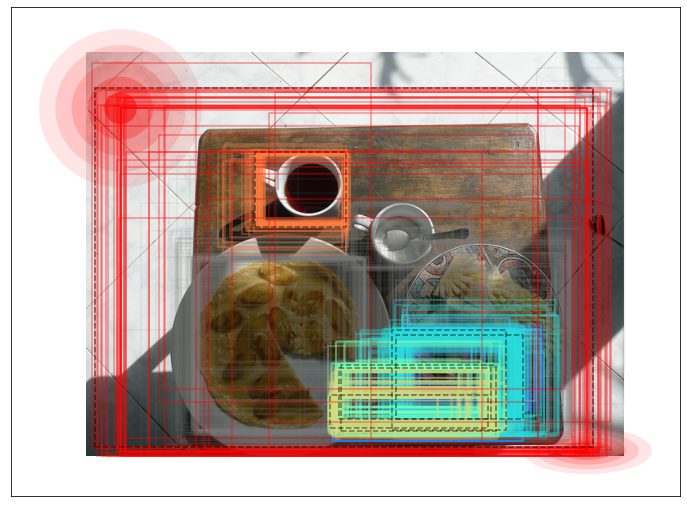

In [14]:
#Whole pipeline

#1-Pick an image
res = dataset['data'][175]

#2- Perform naive bbox density estimation
proposals_tensor, labels, params = naive_estimation(res)

#3- Plot
fig=plt.figure(figsize=(12,9))
image = get_img_from_id(res['image_id'])
plt.imshow(image)
ax = plt.gca()
print(params['mu'])
scatter(proposals_tensor, ax=ax, 
        mu = torch.vstack(params['mu']), 
        cov = torch.vstack(params['cov']),
        labels=labels, 
        avg_scores=params['avg_score'],
        draw_cov=True,
        draw_samples=True
       )
scatter(res['instances'].pred_boxes.tensor, ax=ax, 
        format='proposals',
        color='black',
        linestyle='--')